In [1]:
from matplotlib import pyplot as plt
from IPython import display
import numpy as np
import random
from matplotlib import colors
import copy
import time
import datetime

%matplotlib inline

In [2]:
# assumes periodic BCs
def metropolis_ising(init, boltz):
    """Returns a mesh evolved by one step of applying the Metropolis algorithm, the energy change, 
    and the magnetization change"""
    
    mesh = copy.copy(init)
    
    X = np.shape(mesh)[1]
    Y = np.shape(mesh)[0]
    
    # select random spin from the input spin mesh
    x = random.choice(range(X))
    y = random.choice(range(Y))
    spin = grid[y,x]
    
    # applying the metropolis algorithm
    spin_sum = mesh[(y+1) % Y,x ] + mesh[y ,(x+1) % X] + mesh[(y-1) % Y,x ] + mesh[y ,(x-1) % X]
    d_energy = 2* spin * spin_sum
    
    if d_energy <= 0:
        mesh[y,x] = -1*mesh[y,x]
        d_mag = 2*mesh[y,x]
        
    elif random.uniform(0,1) < boltz[str(abs(spin_sum))]:
        mesh[y,x] = -1*mesh[y,x]
        d_mag = 2*mesh[y,x]
        
    else:
        d_energy = 0
        d_mag = 0
        

    return [mesh, d_energy, d_mag]

In [3]:
def plot_ising_grid(init, title = '', save = False, f_title = None):
    """Creates a discrete colormap for an input Ising grid, black for up (1) and white for down (-1)"""
    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    
    cmap = colors.ListedColormap(['white', 'black'])
    bounds = [0,1,1]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    fig, ax = plt.subplots(figsize=(8,8))
    plt.imshow(init, cmap=cmap, norm=norm)
    plt.title(title, fontsize=20)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

    display.clear_output(wait = True)
    
    if save == True:
        if f_title == None:
            f_title = title
            
        plt.savefig(str(f_title) + '.pdf', bbox_inches='tight')

    plt.show()

In [4]:
def mc_step(init, boltz, n, plot = False, final_only = False):
    """Plots n-step evolution of an Ising model using Metropolis and returns the final grid"""
    
    grid = copy.copy(init)
    
    for i in range(n):    
        # evolve using metropolis
        grid = metropolis_ising(grid, boltz)[0]
        
        if plot == True:
            # plotting
            if final_only == False:    
                plot_ising_grid(grid, f'2D Ising Model; n = {i+1}')


            else:
                if i == n-1:
                    plot_ising_grid(grid, f'2D Ising Model; n = {i+1}')
        
    return grid

In [5]:
# variant of the above that only returns the grid after 1 sweep
# faster than the single-step program when simulating for very long times
def mc_sweep(init, boltz):
    
    grid = copy.copy(init)
    
    X = np.shape(grid)[1]
    Y = np.shape(grid)[0]
    
    for j in range(X):
        for i in range(Y):
            x = np.random.randint(X)
            y = np.random.randint(Y)
            spin = grid[y,x]
            
            spin_sum = grid[(y+1) % Y,x ] + grid[y ,(x+1) % X] + grid[(y-1) % Y,x ] + grid[y ,(x-1) % X]
            d_energy = 2 * spin * spin_sum

            if d_energy <= 0:
                grid[y,x] = -1*grid[y,x]
              #  d_mag = 2*grid[y,x]

            elif random.uniform(0,1) < boltz[str(abs(spin_sum))]:
                grid[y,x] = -1*grid[y,x]
            #    d_mag = 2*grid[y,x]

           # else:
           #     d_energy = 0
           #     d_mag = 0
        
    return grid
                
    

In [6]:
def mult_sweeps(init, boltz, N, plot = False, title = '', save = False, f_title = None):
    """Similar to mc_sweep, but plotting per sweep"""
    
    grid = copy.copy(init)
    
    for n in range(N):
        grid = mc_sweep(grid, boltz)
    
    if plot == True:
        plot_ising_grid(grid, title, save, f_title)
        
    return grid

In [7]:
def ising_energy(init):
    """Computes the energy of a 2D square lattice in the Ising model"""
    
    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    
    energy = 0
    
    for i in range(Y):
        for j in range(X):
            energy += -1 * init[i,j] * (init[(i+1) % Y ,j] + init[(i-1) % Y,j] + init[i,(j+1) % X] + init[i,(j-1) % X])
            
    energy = energy/2
    
    return energy

In [8]:
def energy_evo(init, boltz, n, plot = True):
    """Returns a list of energies for a 2D Ising grid from every timestep and plots the list"""

    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    total = X*Y
    
    grid = copy.copy(init)
    
    # energy
    energy = ising_energy(grid)
    energy_list = [energy]
    
    # evolution
    for i in range(n):
        grid, d_energy, d_mag = metropolis_ising(grid, boltz)
        
        # increment energy
        energy += d_energy
        energy_list.append(energy)

    
    if plot == True:
        # plotting
        x_axis = [i/total for i in range(n+1)]

        plt.figure(figsize=(6,6))
        plt.plot(x_axis,energy_list)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.xlabel('Sweeps', fontsize=20)
        plt.ylabel('Energy', fontsize=20)
        plt.title(f'Energy of Ising Grid', fontsize=20)

    return energy_list


In [9]:
def energy_evo_sweep(init, boltz, N, plot = True):
    """Same as energy_evo, but built on sweeps"""

    grid = copy.copy(init)
    
    # energy
    energy = ising_energy(grid)
    energy_list = [energy]
    
    # evolution
    for i in range(N):
        grid = mc_sweep(grid, boltz)
        energy_list.append(ising_energy(grid))
    
    if plot == True:
        # plotting
        x_axis = [i for i in range(N+1)]

        plt.figure(figsize=(6,6))
        plt.plot(x_axis,energy_list)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.xlabel('Sweeps', fontsize=20)
        plt.ylabel('Energy', fontsize=20)
        plt.title(f'Energy of Ising Grid', fontsize=20)

    return energy_list


In [10]:
def magps(init, boltz, n, plot = True):
    """Returns a list of mag. per spin for a 2D Ising grid from every timestep and plots the list"""

    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    total = X*Y
    
    grid = copy.copy(init)
    
    # magnetization
    mag = np.sum(grid)
    mag_list = [mag]
    
    # evolution
    for i in range(n):
        grid, d_energy, d_mag = metropolis_ising(grid, boltz)
        
        # increment magnetization
        mag += d_mag
        mag_list.append(mag)

    mag_list = np.array(mag_list)/total    
        
    if plot == True:
        # plotting
        x_axis = [i/total for i in range(n+1)]

        plt.figure(figsize=(6,6))
        plt.plot(x_axis,mag_list)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.xlabel('Sweeps', fontsize=20)
        plt.ylabel('Magnetization per Spin', fontsize=20)
        plt.title(f'Magnetization per Spin of Ising Grid', fontsize=20)
    
    
    return mag_list

In [11]:
def magps_sweep(init, boltz, N, plot = True):
    """Returns a list of mag. per spin for a 2D Ising grid from every sweep"""

    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    total = X*Y
    
    grid = copy.copy(init)
    
    # magnetization
    mag = np.sum(grid)
    mag_list = [mag]
    
    # evolution
    for i in range(N):
        grid = mc_sweep(init, boltz)
        
        mag = np.sum(grid)
        mag_list.append(mag)

    mag_list = np.array(mag_list)/total    

    
    
    return mag_list

In [12]:
random.seed(1)
test = np.random.randint(2, size=(100, 100))

for i in range(100):
    for j in range(100):
        if test[i,j] == 0:
            test[i,j] = -1

In [76]:
x_axis = np.arange(0, 10000001, 100)/10000

In [88]:
ones = np.ones((100,100))

T = 2.6
test_boltz = {"4.0" : np.exp(-8/T), "2.0" : np.exp(-4/T)}

In [89]:
grid = copy.copy(ones)


energy = ising_energy(grid)
mag = np.sum(grid)

energy_list = [energy]
mag_list = [mag]


start = time.time()


for i in range(100*100*1000):
    grid, d_energy, d_mag = metropolis_ising(grid, test_boltz)
    
    energy += d_energy
    mag += d_mag
    
    if ((i+1) % 100) == 0:
        energy_list.append(energy)
        mag_list.append(mag)
        
    if ((i+1) % 1000000) == 0:
        tick = time.time()
        print(f'Sweep {(i+1)/10000}; {tick-start} seconds')
        
energy_list = np.array(energy_list)/10000
mag_list = np.array(mag_list)/10000
    

Sweep 100.0; 13.384894847869873 seconds
Sweep 200.0; 26.51073431968689 seconds
Sweep 300.0; 39.698837757110596 seconds
Sweep 400.0; 52.793232679367065 seconds
Sweep 500.0; 66.32531523704529 seconds
Sweep 600.0; 79.51348924636841 seconds
Sweep 700.0; 92.62358975410461 seconds
Sweep 800.0; 105.78056406974792 seconds
Sweep 900.0; 118.96873927116394 seconds
Sweep 1000.0; 132.11023712158203 seconds


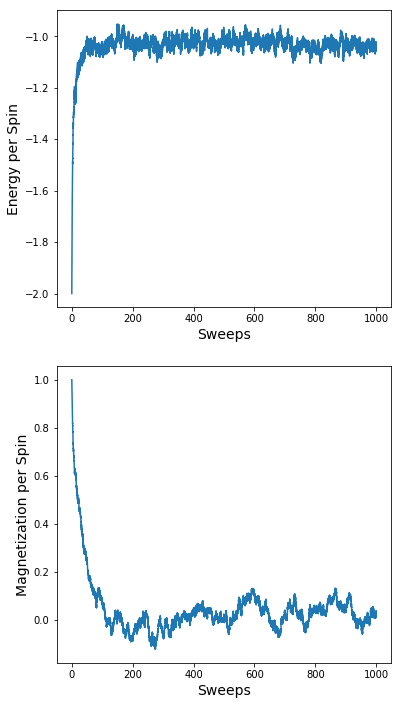

In [91]:
fig = plt.figure(figsize=(6, 12)) 

fig.add_subplot(2, 1, 1 )
plt.plot(x_axis, energy_list)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('Sweeps', fontsize=14)
plt.ylabel('Energy per Spin', fontsize=14)

fig.add_subplot(2, 1, 2 )
plt.plot(x_axis, mag_list)
plt.tick_params(axis='both', whicbh='major', labelsize=10)
plt.xlabel('Sweeps', fontsize=14)
plt.ylabel('Magnetization per Spin', fontsize=14)

#plt.savefig('Equilibration2.pdf', bbox_inches = 'tight')

In [92]:
np.save('equilT26_ene100_1000.npy', energy_list)
np.save('equilT26_mag100_1000.npy', mag_list)

In [14]:
boltzlist = [{"4.0" : np.exp(-8/.01), "2.0" : np.exp(-4/.01)},{"4.0" : np.exp(-8/2), "2.0" : np.exp(-4/2)},
            {"4.0" : np.exp(-8/3), "2.0" : np.exp(-4/3)}, {"4.0" : np.exp(-8/100), "2.0" : np.exp(-4/100)}]

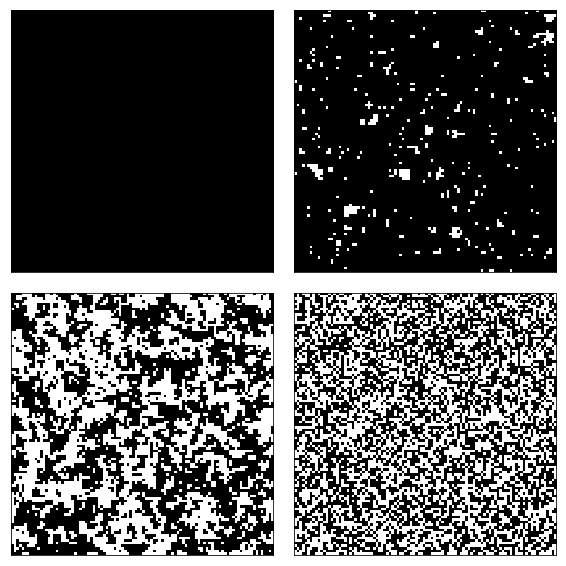

In [23]:
f, axes = plt.subplots(2,2)
f.set_size_inches(8,8)
plt.tight_layout(pad=0, w_pad=-1, h_pad=-1)

cmap = colors.ListedColormap(['white', 'black'])
bounds = [0,1,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

axarr = np.ndarray.flatten(axes)

for ax, num in zip(axarr, range(4)):
    output = mult_sweeps(ones, boltzlist[num], 500)
    ax.imshow(output, cmap=cmap, norm=norm)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    
plt.savefig('4 Temps.pdf', bbox_inches='tight')

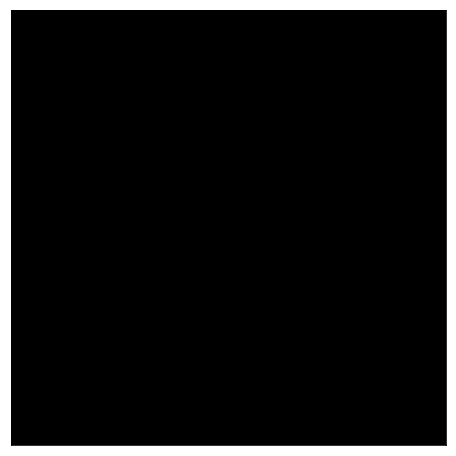

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [118]:
random.seed(1)
mult_sweeps(ones, test_boltz, 0, plot = True, save = True, f_title = 'N=0')

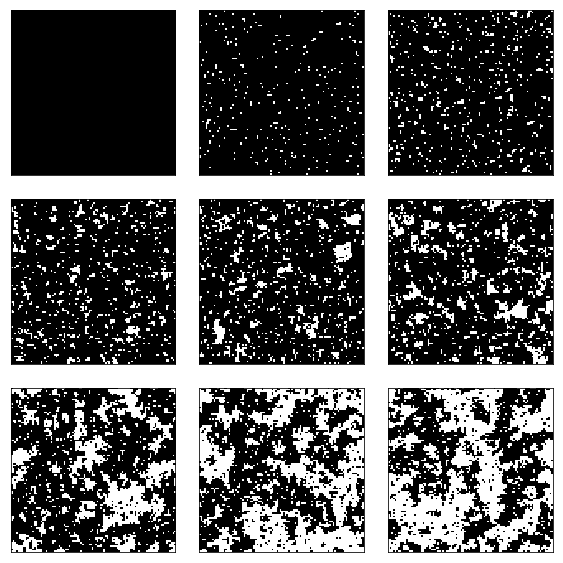

In [139]:
f, axes = plt.subplots(3,3)
f.set_size_inches(8,8)
plt.tight_layout(pad=0, w_pad=-1, h_pad=-1)

cmap = colors.ListedColormap(['white', 'black'])
bounds = [0,1,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

axarr = np.ndarray.flatten(axes)
numsweeps = [0, 1,5,10,20,50,100, 500,1000] 

for ax, num in zip(axarr, numsweeps):
    output = mult_sweeps(ones, test_boltz, num)
    ax.imshow(output, cmap=cmap, norm=norm)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    
plt.savefig('Lattice evolution.pdf', bbox_inches='tight')

In [22]:
grid = np.ones((100,100))

T = 2.6
test_boltz = {"4.0" : np.exp(-8/T), "2.0" : np.exp(-4/T)}

# energy
energy = ising_energy(grid)
energy_list = [energy]

# mag
mag = np.sum(grid)
mag_list = [mag]

print(datetime.datetime.now().time())
start = time.time()

# evolution
for i in range(2000*100*100):
    grid, d_energy, d_mag = metropolis_ising(grid, test_boltz)

    # increment
    energy += d_energy
    energy_list.append(energy)
    mag += d_mag
    mag_list.append(mag)
    
    if ((i+1) % 4000000) == 0:
        tick = time.time()
        print(f'Sweep {(i+1)/10000}; {tick - start} seconds')
    
mag_list = np.array(mag_list)/(100*100)

# plotting
x_axis = [i/(100*100) for i in range(2000*100*100+1)]


fig = plt.figure(figsize=(6, 12))

fig.add_subplot(2,1, 1)
plt.plot(x_axis,energy_list)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))
plt.xlabel('Sweeps', fontsize=14)
plt.ylabel('Energy [J]', fontsize=14)

fig.add_subplot(2,1, 2)
plt.plot(x_axis, mag_list)
plt.tick_params(axis='both', which='mjor', labelsize=10)
plt.xlabel('Sweeps', fontsize=14)
plt.ylabel('Mag. per spin', fontsize=14)

plt.savefig('Equilibration4.pdf', bbox_inches='tight')

22:54:54.687796
Sweep 400.0; 54.41437888145447 seconds
Sweep 800.0; 109.13594508171082 seconds
Sweep 1200.0; 163.08439373970032 seconds
Sweep 1600.0; 216.68148851394653 seconds
Sweep 2000.0; 270.7658050060272 seconds


MemoryError: 

MemoryError: 